<a href="https://colab.research.google.com/github/Mountain-C/Class-Projects/blob/master/Class-Projects/Codes/Numerical_Analysis/Make_A_function_to_create_A_matrix_and_b_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
%precision 3
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
# from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
# from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

def Poisson_2D_Dirichlet_FD(X, Y, RHS_f, DBC):
    """ Form/assemble the discretised Poisson problem in 2D 
    using second-order finite differences,
    with the RHS function given by RHS_F 
    and Dirichlet boundary conditions given in the function DBC.
    As we assume Dirichlet BCs in this implementation, here we return 
    the "interior" mesh data structures X_int, i_int etc, and the 
    associated discretised A matrix and RHS vector.
    We don't actually solve the assembled system in this function.
    """
    Nx = np.shape(X)[0]
    Ny = np.shape(Y)[1]
    # our code below is only currently for the case Nx=Ny (and dx=dy)
    assert Nx == Ny
    
    # ID the boundary nodes - initialise the ID to 1 for ALL nodes
    bndry_node = np.ones_like(X)
    # and overwrite with zeros for the interior nodes, leaving 1 only on boundary 
    bndry_node[1:-1, 1:-1] = 0

    # we won't be solving for boundary node values, so define data strucutres
    # for the domain "interior"
    i_int = np.arange(1, Nx-1)
    j_int = np.arange(1, Ny-1)

    # the mesh in the interior - read the docs to see what `numpy.ix_` does:
    # "Using ix_ one can quickly construct index arrays that will index the 
    # cross product. 
    # a[np.ix_([1,3],[2,5])] returns the array [[a[1,2] a[1,5]], [a[3,2] a[3,5]]]."
    X_int = X[np.ix_(i_int, j_int)]
    Y_int = Y[np.ix_(i_int, j_int)]

    # form the LHS discretisation matrix which is built up from some
    # fundamental matrices in x and y
    ex = np.ones((Nx - 2, 1))
    ey = np.ones((Ny - 2, 1))

    Tx = np.diagflat(ex[1:], k=-1) - 2*np.diagflat(ex, k=0) + np.diagflat(ex[1:], k=1)
    Ty = np.diagflat(ey[1:], k=-1) - 2*np.diagflat(ey, k=0) + np.diagflat(ey[1:], k=1)

    # this is using the Kronecker product to arrive at the desired discretisation matrix
    # could equally well assemble the discretisation matrix via the appropriate loops
    # here 
    A_int = (np.kron(np.eye(Ny-2), Tx) + np.kron(Ty, np.eye(Nx-2))) / dx**2
    
    print(A_int)
       
    # Use the given function f to set the RHS
    RHS_int = RHS_f(X_int,Y_int)

    # and update the RHS based on given Dirichlet BCs
    RHS_int[:, 0] = RHS_int[:, 0] - DBC(X[i_int, 0], Y[i_int, 0]) / dx**2
    RHS_int[:, -1] = RHS_int[:, -1] - DBC(X[i_int, -1], Y[i_int, -1]) / dx**2
    RHS_int[0, :] = RHS_int[0, :] - DBC(X[0, j_int], Y[0, j_int]) / dx**2
    RHS_int[-1, :] = RHS_int[-1, :] - DBC(X[-1, j_int], Y[-1, j_int]) /dx**2   
   
    # row-major numbering
    RHS_int = RHS_int.flatten('C')
    
    return A_int, RHS_int, X_int, Y_int, i_int, j_int

# we'll assume uniform mesh in x and y direction for simplicity
# can easily be generalised

# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 7
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y

# Give the functions defining our problem

# If we know the exact solution we can compute exact errors
def c_exact(X,Y):
  return X*(X-Y)**3
#     return np.sin(2*np.pi*X)*np.sinh(2*np.pi*Y)/np.sinh(2*np.pi)

# A function giving the RHS
def RHS_f(X,Y):
    return np.zeros_like(X)

# A function to return Dirichlet BCs - if we have an exact solution we can 
# just point at that.
def DBC(X,Y):
    return c_exact(X,Y)

A_int, RHS_int, X_int, Y_int, i_int, j_int = Poisson_2D_Dirichlet_FD(X,Y,RHS_f,DBC)

[[-144.   36.    0.    0.    0.   36.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [  36. -144.   36.    0.    0.    0.   36.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.   36. -144.   36.    0.    0.    0.   36.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.    0.   36. -144.   36.    0.    0.    0.   36.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.    0.    0.   36. -144.    0.    0.    0.    0.   36.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [  36.    0.    0.    0.    0. -144.   36.    0.    0.    0.   36.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.   36.    0.    0.    0.   36. -144.   36.    0.   

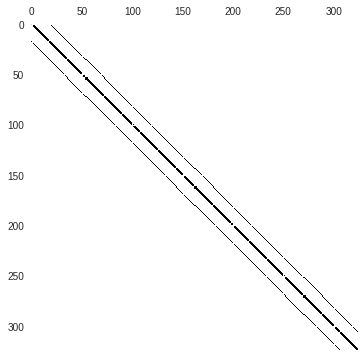

In [ ]:
import matplotlib.pyplot as plt

# plot the sparsity pattern of A
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.spy(A_int);

Error (RMS) = 5.9020e-02
Error (inf) = 1.5968e-01


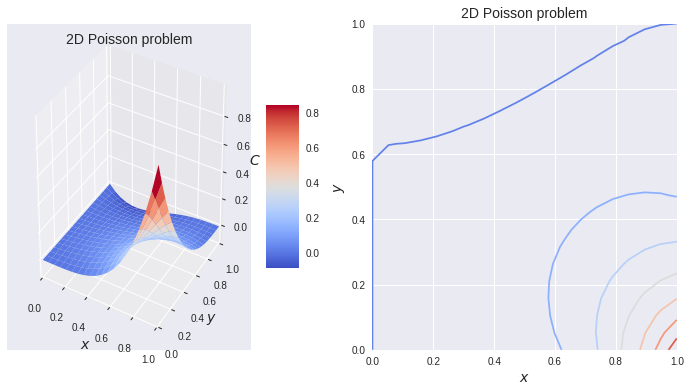

In [ ]:
# solve and plot solution
from mpl_toolkits.mplot3d import Axes3D

# solve using scipy's solve (a direct method)
C_int = sl.solve(A_int, RHS_int)

# revert back to a 2D numbering format
c_int = C_int.reshape(np.shape(X_int))

# Initialise the full solution over the entire domain via a copy of the exact solution
c = np.copy(c_exact(X,Y))
# overwrite all but the BC values with our interior numerical solution
c[np.ix_(i_int, j_int)] = c_int
# plot the solution as a 3D surface
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, c, rstride=1, cstride=1,
                       cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_zlabel('$C$', fontsize=14)
ax.set_title('2D Poisson problem', fontsize=14)

# plot the solution as a 2D contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X, Y, c, cmap=cm.coolwarm)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_title('2D Poisson problem', fontsize=14)

print('Error (RMS) = %.4e' % (sl.norm(c_exact(X,Y) - c,  'fro')/(np.sqrt(Nx*Ny))))
print('Error (inf) = %.4e' % (np.max(np.fabs(c_exact(X,Y) - c))))

In [ ]:
from IPython.core.display import display, HTML
import json
import numpy as np

def plot3D(X, Y, Z, height=600, xlabel = "X", ylabel = "Y", zlabel = "Z", initialCamera = None):

    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }

    if initialCamera:
        options["cameraPosition"] = initialCamera
        
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))


In [ ]:
plot3D(X, Y, c)

In [ ]:

import os
import math
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

def make_A(k):
    """Create the matrix for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Poisson's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for i in range(k):
        for j in range(k):
            # what row of the matrix is grid point (i, j)?
            row = j + i*k
            # the diagonal element in this row
            triples.append((row, row, 4.0))
            # connect to left grid neighbor
            if j > 0:
                triples.append((row, row - 1, -1.0))
            # ... right neighbor
            if j < k - 1:
                triples.append((row, row + 1, -1.0))
            # ... neighbor above
            if i > 0:
                triples.append((row, row - k, -1.0))
            # ... neighbor below
            if i < k - 1:
                triples.append((row, row + k, -1.0))
    
    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A

def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b


def radiator(k, width = .3, temperature = 100.):
    """Create one wall with a radiator
    Parameters: 
      k: number of grid points in each dimension; length of the wall.
      width: width of the radiator as a fraction of length of the wall (defaults to 0.2)
      temperature: temperature of the radiator (defaults to 100)
    Outputs:
      wall: the k element vector (as a numpy array) for the boundary conditions at the wall
    """
    rad_start = int(k * (0.5 - width/2))
    rad_end = int(k * (0.5 + width/2))
    wall = np.zeros(k)
    wall[rad_start : rad_end] = temperature
    
    return wall

In [ ]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)

k = 7
rad_wall = radiator(k)
print(rad_wall)
A = make_A(k)
# print(A.toarray()[:, :])
b = make_b(k, right = rad_wall)
A.shape

[  0.   0. 100. 100.   0.   0.   0.]


(49, 49)

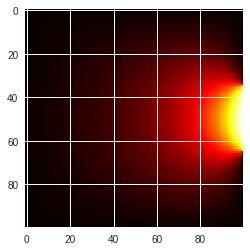

In [ ]:

t = spla.spsolve(A,b)
T = t.reshape(k,k)

plt.figure()
plt.imshow(T, cmap=cm.hot)
plt.savefig("tempProblem.png", format='png', bbox_inches='tight')

In [ ]:

def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right       
    
    return b

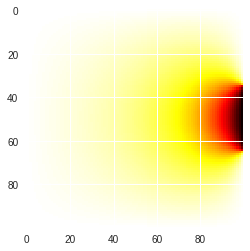

In [ ]:

k = 100
rad_wall = radiator(k)
A = make_A(k)
b = make_b(k, right = rad_wall)
A.shape

t = spla.spsolve(A,b)
T = t.reshape(k,k)

plt.figure()
plt.imshow(T, cmap=cm.hot)
plt.savefig("tempProblem_bug.png", format='png', bbox_inches='tight')